![Texto alternativo](https://cdn-ilbdkgn.nitrocdn.com/KyPgQQQAVfBmOoLeBzkzAekksAGOgYiS/assets/images/optimized/rev-507152b/www.modernheartandvascular.com/wp-content/uploads/2022/10/HEart-failure.png)

El objetivo de este proyecto es construir un modelo de Machine Learning que pueda predecir si un paciente tiene una enfermedad cardíaca basándonos en sus características médicas.

🔍 1. Predicción del riesgo de enfermedad cardiovascular

¿Es probable que un paciente desarrolle una enfermedad cardiovascular?


📊 2. Factores de riesgo más influyentes

¿Cuáles son las variables más importantes en la predicción del riesgo?


⚖️ 3. Evaluación de impacto de hábitos y condiciones

¿Cómo influyen el tabaquismo, el alcohol o la inactividad física en el riesgo?

¿Qué combinación de factores aumenta más la probabilidad de enfermedad?

🏥 4. Personalización del tratamiento/previsión

¿Cómo se pueden agrupar los pacientes según su riesgo?



⏳ 5. Predicción temprana de riesgo cardiovascular
¿Se puede predecir si una persona desarrollará una enfermedad en el futuro?

🎯 6. Comparación de modelos de predicción
¿Qué modelo predice mejor el riesgo? (Random Forest, XGBoost, SVM, etc.)


## Cargar librerias y Dataset

In [2]:
# Librerías básicas
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Preprocesamiento de datos
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE

# División de datos
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

# Modelos de Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Ensembling
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import StackingClassifier

# Evaluación de modelos
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    confusion_matrix,
    roc_curve
)

# Cargar los datos
df = pd.read_csv("./data/heart.csv")



c:\Users\Carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Estructura del Dataset

In [3]:
# Ver primeras filas
print(df.head())

# Información general
print(df.info())

# Resumen estadístico
print(df.describe())


   age     sex chest_pain_type  resting_blood_pressure  cholestoral  \
0   52    Male  Typical angina                     125          212   
1   53    Male  Typical angina                     140          203   
2   70    Male  Typical angina                     145          174   
3   61    Male  Typical angina                     148          203   
4   62  Female  Typical angina                     138          294   

      fasting_blood_sugar               rest_ecg  Max_heart_rate  \
0    Lower than 120 mg/ml  ST-T wave abnormality             168   
1  Greater than 120 mg/ml                 Normal             155   
2    Lower than 120 mg/ml  ST-T wave abnormality             125   
3    Lower than 120 mg/ml  ST-T wave abnormality             161   
4  Greater than 120 mg/ml  ST-T wave abnormality             106   

  exercise_induced_angina  oldpeak        slope vessels_colored_by_flourosopy  \
0                      No      1.0  Downsloping                           Two   
1 

Nos encontramos ante un dataset con 1025 filas, 14 columnas.
De los cuales, 5 variables son numéricas (int64 o float64)
8 variables son categóricas (object) y la variable objetivo (target) es binaria: 

0 = No enfermedad

1 = Enfermedad.


•	Edad (age)

•	Sexo (sex)

•	Presión arterial en reposo (trestbps)

•	Colesterol (chol)

•	Frecuencia cardíaca máxima alcanzada (thalach)

•	Angina inducida por ejercicio (exang)

•	Depresión del ST inducida por el ejercicio (oldpeak)

•	Tipo de dolor en el pecho (cp - diferentes tipos de dolor)

•	Results de electrocardiograma en reposo (restecg)

Se observa:
Varias columnas categóricas (sex, chest_pain_type, etc.) deben ser convertidas a variables numéricas.

La columna cholestoral parece tener valores altos (máx: 564), posible outlier.

La columna vessels_colored_by_flourosopy tiene valores en texto que podrían requerir limpieza.

In [4]:
# Convertir columnas categóricas a numéricas
categorical_mappings = {
    'sex': {'Male': 1, 'Female': 0},
    'chest_pain_type': {
        'Typical angina': 0, 'Atypical angina': 1, 'Non-anginal pain': 2, 'Asymptomatic': 3
    },
    'fasting_blood_sugar': {'Lower than 120 mg/ml': 0, 'Greater than 120 mg/ml': 1},
    'rest_ecg': {'Normal': 0, 'ST-T wave abnormality': 1, 'Left ventricular hypertrophy': 2},
    'exercise_induced_angina': {'No': 0, 'Yes': 1},
    'slope': {'Upsloping': 0, 'Flat': 1, 'Downsloping': 2},
    'vessels_colored_by_flourosopy': {'Zero': 0, 'One': 1, 'Two': 2, 'Three': 3, 'Four': 4},
    'thalassemia': {'Normal': 0, 'Fixed Defect': 1, 'Reversable Defect': 2}
}

# Aplicar las conversiones
for col, mapping in categorical_mappings.items():
    df[col] = df[col].map(mapping)

# Manejo de outliers en 'cholestoral' (usando percentil 99 para detectar valores extremos)
cholesterol_threshold = np.percentile(df['cholestoral'], 99)
df = df[df['cholestoral'] <= cholesterol_threshold]

# Mostrar resultados
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            1016 non-null   int64  
 1   sex                            1016 non-null   int64  
 2   chest_pain_type                1016 non-null   int64  
 3   resting_blood_pressure         1016 non-null   int64  
 4   cholestoral                    1016 non-null   int64  
 5   fasting_blood_sugar            1016 non-null   int64  
 6   rest_ecg                       1016 non-null   int64  
 7   Max_heart_rate                 1016 non-null   int64  
 8   exercise_induced_angina        1016 non-null   int64  
 9   oldpeak                        1016 non-null   float64
 10  slope                          1016 non-null   int64  
 11  vessels_colored_by_flourosopy  1016 non-null   int64  
 12  thalassemia                    1009 non-null   float6

(None,
    age  sex  chest_pain_type  resting_blood_pressure  cholestoral  \
 0   52    1                0                     125          212   
 1   53    1                0                     140          203   
 2   70    1                0                     145          174   
 3   61    1                0                     148          203   
 4   62    0                0                     138          294   
 
    fasting_blood_sugar  rest_ecg  Max_heart_rate  exercise_induced_angina  \
 0                    0         1             168                        0   
 1                    1         0             155                        1   
 2                    0         1             125                        1   
 3                    0         1             161                        0   
 4                    1         1             106                        0   
 
    oldpeak  slope  vessels_colored_by_flourosopy  thalassemia  target  
 0      1.0      2          

Faltan algunos valores en thalassemia (7 valores nulos), procedemos a eliminarlo ya que nos pocos (7 frente a  1016)

In [5]:
# Eliminar filas con valores nulos en 'thalassemia'
df = df.dropna(subset=['thalassemia'])

# Verificar que no hay valores nulos
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1009 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            1009 non-null   int64  
 1   sex                            1009 non-null   int64  
 2   chest_pain_type                1009 non-null   int64  
 3   resting_blood_pressure         1009 non-null   int64  
 4   cholestoral                    1009 non-null   int64  
 5   fasting_blood_sugar            1009 non-null   int64  
 6   rest_ecg                       1009 non-null   int64  
 7   Max_heart_rate                 1009 non-null   int64  
 8   exercise_induced_angina        1009 non-null   int64  
 9   oldpeak                        1009 non-null   float64
 10  slope                          1009 non-null   int64  
 11  vessels_colored_by_flourosopy  1009 non-null   int64  
 12  thalassemia                    1009 non-null   float6

In [6]:
#Comprobamos que no hay valores nulos
df.isnull().sum()

age                              0
sex                              0
chest_pain_type                  0
resting_blood_pressure           0
cholestoral                      0
fasting_blood_sugar              0
rest_ecg                         0
Max_heart_rate                   0
exercise_induced_angina          0
oldpeak                          0
slope                            0
vessels_colored_by_flourosopy    0
thalassemia                      0
target                           0
dtype: int64

In [7]:
#Pacientes con enfermedad
countNoDisease = len(df[df.target == 0])
countHaveDisease = len(df[df.target == 1])
print("% de pacientes con enfermedad cardiovascular: {:.2f}%".format((countNoDisease / (len(df.target))*100)))
print("% de pacientes sin enfermedad cardiovascular: {:.2f}%".format((countHaveDisease / (len(df.target))*100)))

% de pacientes con enfermedad cardiovascular: 48.76%
% de pacientes sin enfermedad cardiovascular: 51.24%


## MINI EDA

Distribución de la Variable objetico

C:\Users\Carol\AppData\Local\Temp\ipykernel_20468\2831841322.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["target"], palette="coolwarm")


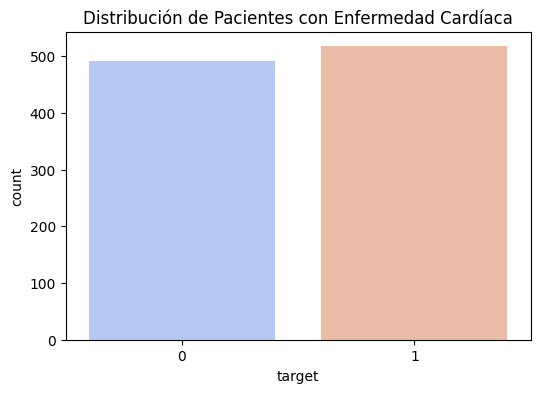

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["target"], palette="coolwarm")
plt.title("Distribución de Pacientes con Enfermedad Cardíaca")
plt.show()


Tenemos una variable target balanceada

Correlación entre variabbles

In [9]:
# Usamos LabelEncoder para transformar las categorías en números
encoder = LabelEncoder()
for col in categorical_mappings:
    df[col] = encoder.fit_transform(df[col])

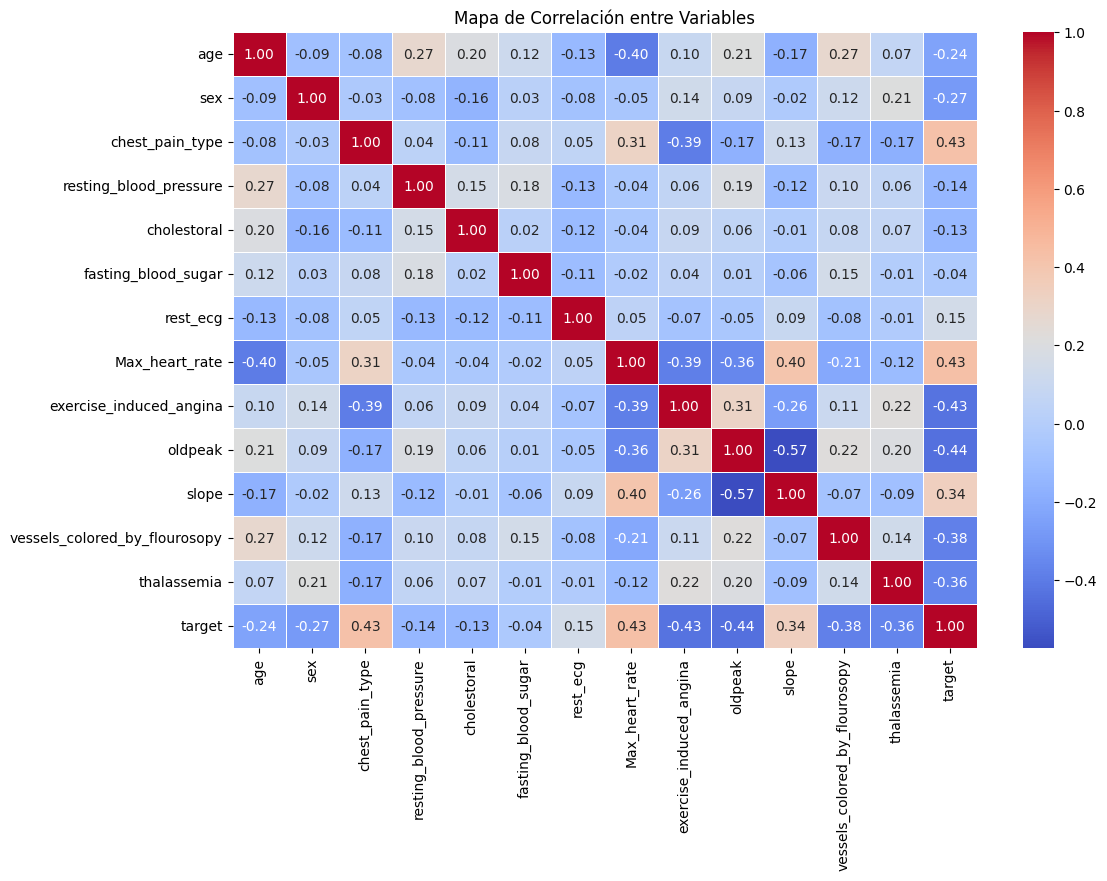

In [10]:
# Mapa de calor de correlaciones
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Mapa de Correlación entre Variables")
plt.show()


De este análisis se puede concluir:

Max_heart_rate y target tienen correlación positiva (0.40), lo que indica que una mayor frecuencia cardíaca máxima puede estar asociada con la enfermedad.

Oldpeak (Depresión del ST) tiene correlación negativa (-0.57) con target, lo que sugiere que valores más altos pueden indicar menor riesgo.

Chest_pain_type tiene correlación positiva fuerte (0.43) con la variable target, lo que indica que el tipo de dolor en el pecho es un buen predictor.

Algunas variables (cholestoral, resting_blood_pressure) no parecen estar fuertemente correlacionadas con target, por lo que podrían no ser tan relevantes.

 Distribución de Pacientes según Edad y Género

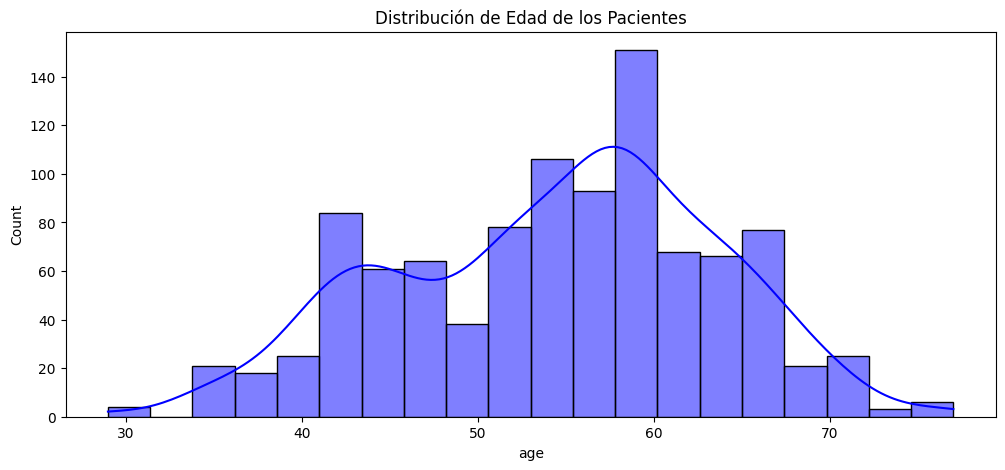

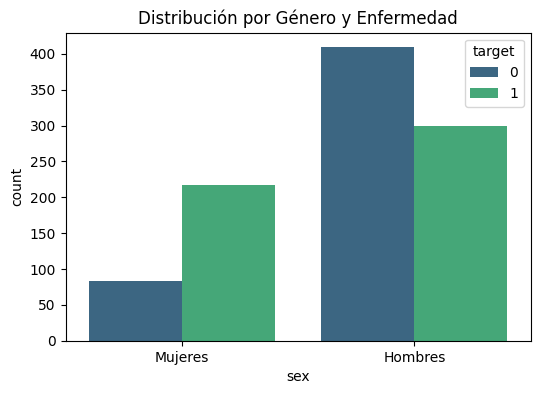

In [11]:
plt.figure(figsize=(12,5))
sns.histplot(df["age"], bins=20, kde=True, color="blue")
plt.title("Distribución de Edad de los Pacientes")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x=df["sex"], hue=df["target"], palette="viridis")
plt.xticks([0, 1], ["Mujeres", "Hombres"])
plt.title("Distribución por Género y Enfermedad")
plt.show()


De este análisis se concluye que la mayoría de los pacientes con enfermedad son mayores de cierta edad por lo que la edad puede ser un factor clave para padecer la enfermedad de estudio.

Las mujeres tienen menor riesgo de padecer la enfermedad que los hombres.


## Revisión de datos

 Manejo de Datos Categóricos
Algunas variables en el dataset son categóricas y deben ser convertidas en formato numérico si aún no lo están.

In [12]:
# Convertir variables categóricas en numéricas
categorical_cols = ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'rest_ecg', 
                    'exercise_induced_angina', 'slope', 'vessels_colored_by_flourosopy', 'thalassemia']



Normalización de Variables Numéricas

Para mejorar el desempeño de algunos modelos, escalamos los datos con StandardScaler.

In [13]:
# Normalizar variables numéricas:
scaler = StandardScaler()
numerical_cols = ['age', 'resting_blood_pressure', 'cholestoral', 'Max_heart_rate', 'oldpeak']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])



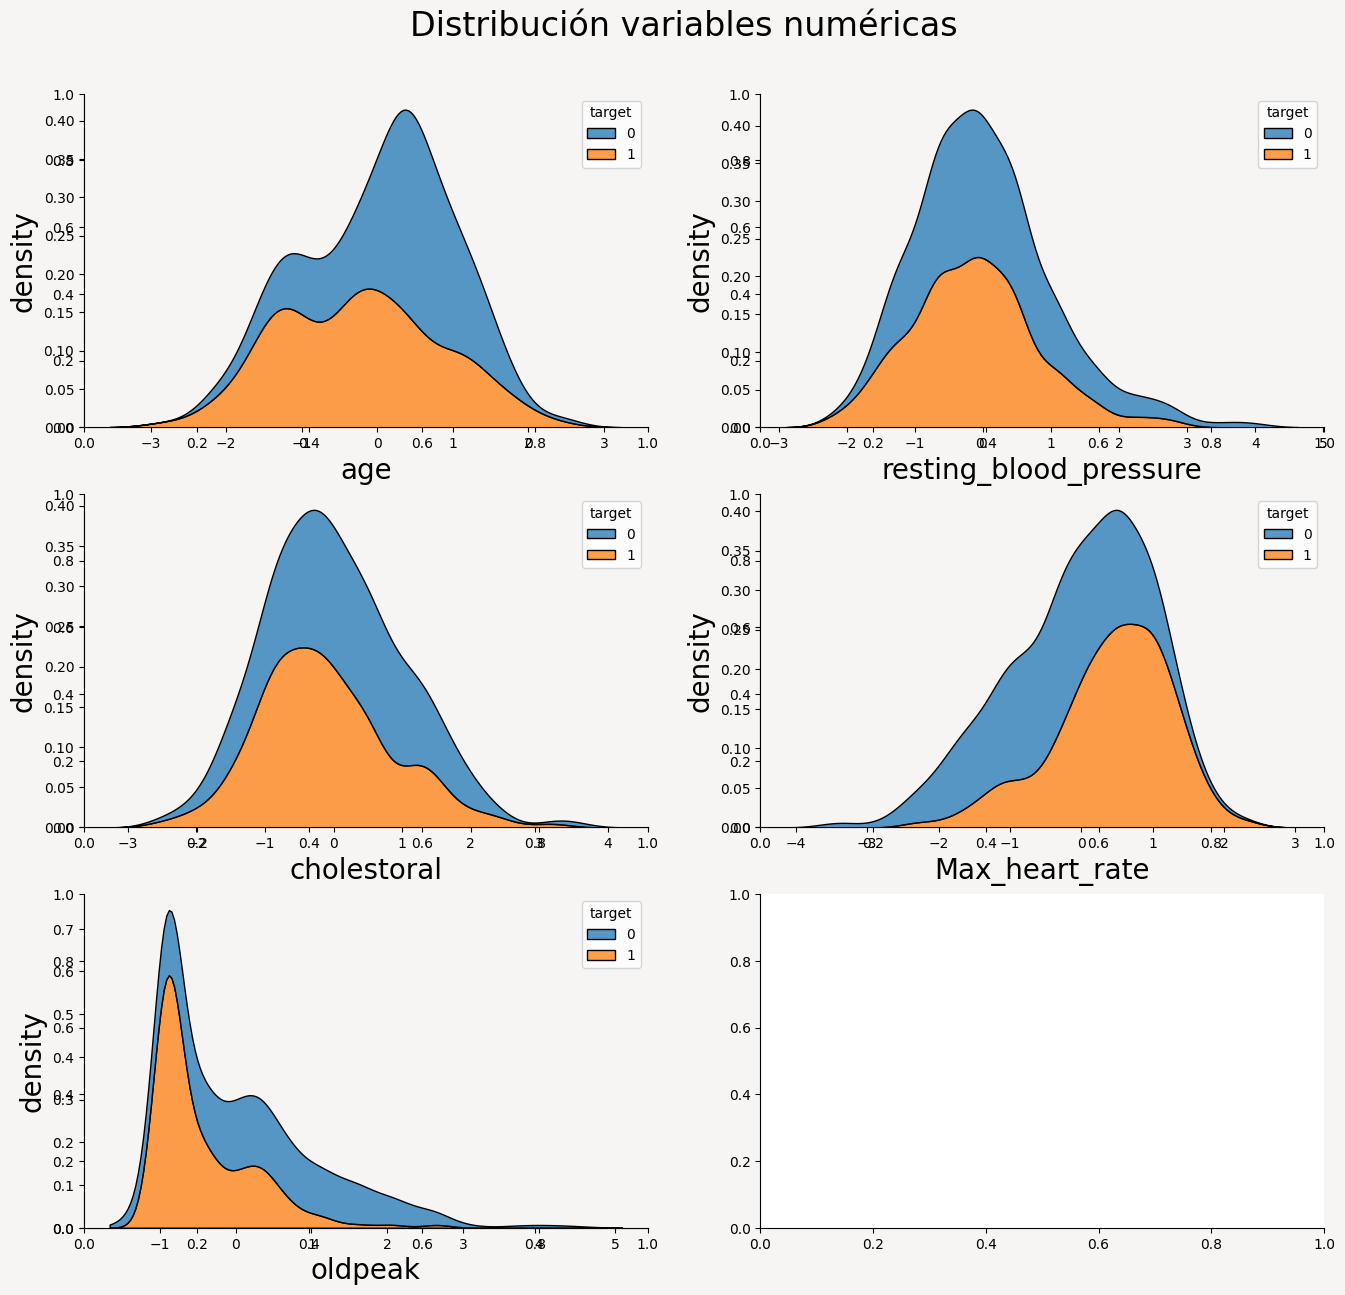

In [14]:
#Representamos la distribución de las variables numéricas

L = len(numerical_cols)
ncol= 2
nrow= int(np.ceil(L/ncol))


fig, ax = plt.subplots(nrow, ncol, figsize=(16, 14),facecolor='#F6F5F4')   
fig.subplots_adjust(top=0.92)

i = 1
for col in numerical_cols:
    plt.subplot(nrow, ncol, i, facecolor='#F6F5F4')
    
    ax = sns.kdeplot(data=df, x=col, hue="target", multiple="stack") 
    ax.set_xlabel(col, fontsize=20)
    ax.set_ylabel("density", fontsize=20)
    sns.despine(right=True)
    sns.despine(offset=0, trim=False)
    
    if col == 'num_major_vessels':
        sns.countplot(data=df, x=col, hue="target")
        for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.0f}'.format((height)),ha="center",
                      bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))
    
    i = i +1
plt.suptitle('Distribución variables numéricas' ,fontsize = 24);

Ahora dividimos es dataset en Train/Test para tener los datos en conjuntos de entrenamiento y de prueba.

In [15]:
# Separar variables predictoras y objetivo
X = df.drop("target", axis=1)
y = df["target"]

# Dividir en 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verificar tamaño de los conjuntos
X_train.shape, X_test.shape



((807, 13), (202, 13))

## Predicción

Nos encontramos ante un problema de clasificación binaria. Scikit Learn ofrece una amplia gama de algoritmos de clasificación y es a menudo el punto de partida en la mayoría de los desafíos tradicionales de aprendizaje automático. Por lo tanto, construiremos modelos simples utilizando algoritmos de ML y luego los optimizaremos ajustando los parámetros.

In [16]:
# Modelo de regresión logística
m1 = 'Logistic Regression'
lr = LogisticRegression()
model = lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print("Matriz de confusión:")
print(lr_conf_matrix)
print("\n")
print("Precisión del Modelo:",lr_acc_score*100,'\n')
print(classification_report(y_test,lr_predict))

Matriz de confusión:
[[ 78  20]
 [  3 101]]


Precisión del Modelo: 88.61386138613861 

              precision    recall  f1-score   support

           0       0.96      0.80      0.87        98
           1       0.83      0.97      0.90       104

    accuracy                           0.89       202
   macro avg       0.90      0.88      0.88       202
weighted avg       0.90      0.89      0.89       202



El modelo de Regresión Logística tiene un buen rendimiento con una precisión de 88.61% en la predicción de la enfermedad cardiovascular.

Es más efectivo para identificar a los pacientes con enfermedad cardiovascular (alto recall), pero puede mejorar la identificación de aquellos sin la enfermedad (mejorar el recall para clase 0).

El modelo ha logrado un buen equilibrio entre precisión y recall, especialmente para los pacientes con la enfermedad, lo que lo hace útil para detectar riesgos de enfermedad cardiovascular.

In [17]:
# Modelo de Naive Bayes:
m2 = 'Naive Bayes'
nb = GaussianNB()
nb.fit(X_train,y_train)
nbpred = nb.predict(X_test)
nb_conf_matrix = confusion_matrix(y_test, nbpred)
nb_acc_score = accuracy_score(y_test, nbpred)
print("Matriz de Confussion")
print(nb_conf_matrix)
print("\n")
print("Precisión del Modelo:",nb_acc_score*100,'\n')
print(classification_report(y_test,nbpred))

Matriz de Confussion
[[78 20]
 [ 9 95]]


Precisión del Modelo: 85.64356435643565 

              precision    recall  f1-score   support

           0       0.90      0.80      0.84        98
           1       0.83      0.91      0.87       104

    accuracy                           0.86       202
   macro avg       0.86      0.85      0.86       202
weighted avg       0.86      0.86      0.86       202



El modelo de Naive Bayes ha logrado una precisión del 85.64% en el conjunto de prueba, lo que es bastante bueno.

Tiene un alto recall para pacientes con enfermedad cardiovascular (91%), lo que significa que es muy efectivo para detectar a los pacientes que realmente la tienen.

Sin embargo, la precisión para pacientes sin enfermedad cardiovascular es algo más baja (90%), y el recall también podría mejorarse.

En general, el modelo ofrece un buen balance entre precisión y recall, lo que lo hace útil para la detección de la enfermedad cardiovascular.

In [18]:
# Modelo de clasificación Random Forest
m3 = 'Random Forest Classfier'
rf = RandomForestClassifier(n_estimators=20, random_state=12,max_depth=5)
rf.fit(X_train,y_train)
rf_predicted = rf.predict(X_test)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)
rf_acc_score = accuracy_score(y_test, rf_predicted)
print("Matriz de Confussion")
print(rf_conf_matrix)
print("\n")
print("Precisión del Modelo:",rf_acc_score*100,'\n')
print(classification_report(y_test,rf_predicted))

Matriz de Confussion
[[ 91   7]
 [  2 102]]


Precisión del Modelo: 95.54455445544554 

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        98
           1       0.94      0.98      0.96       104

    accuracy                           0.96       202
   macro avg       0.96      0.95      0.96       202
weighted avg       0.96      0.96      0.96       202



El modelo de Random Forest tiene una precisión del 95.54% en el conjunto de prueba, lo que indica que hace predicciones correctas en la mayoría de los casos.

Tiene un recall muy alto para pacientes con enfermedad cardiovascular (98%), lo que significa que casi todos los pacientes con la enfermedad son detectados correctamente.

La precisión es igualmente alta (94%), lo que sugiere que pocos pacientes sin la enfermedad son clasificados incorrectamente como si la tuvieran.

En general, el modelo de Random Forest ofrece un rendimiento excelente para la predicción de la enfermedad cardiovascular, siendo muy efectivo tanto para la clase positiva como para la negativa.

In [19]:
# Modelo de XGBoost
m4 = 'Extreme Gradient Boost'
xgb = XGBClassifier(learning_rate=0.01, n_estimators=25, max_depth=15,gamma=0.6, subsample=0.52,colsample_bytree=0.6,seed=27, 
                    reg_lambda=2, booster='dart', colsample_bylevel=0.6, colsample_bynode=0.5)
xgb.fit(X_train, y_train)
xgb_predicted = xgb.predict(X_test)
xgb_conf_matrix = confusion_matrix(y_test, xgb_predicted)
xgb_acc_score = accuracy_score(y_test, xgb_predicted)
print("Matriz de Confussion")
print(xgb_conf_matrix)
print("\n")
print("Precisión del Modelo:",xgb_acc_score*100,'\n')
print(classification_report(y_test,xgb_predicted))

Matriz de Confussion
[[ 81  17]
 [  2 102]]


Precisión del Modelo: 90.5940594059406 

              precision    recall  f1-score   support

           0       0.98      0.83      0.90        98
           1       0.86      0.98      0.91       104

    accuracy                           0.91       202
   macro avg       0.92      0.90      0.90       202
weighted avg       0.91      0.91      0.91       202



El modelo de XGBoost tiene una precisión del 90.59%, lo que indica que hace predicciones correctas en la mayoría de los casos.

El recall para pacientes con enfermedad cardiovascular (98%) es muy alto, lo que significa que casi todos los pacientes enfermos son correctamente detectados.

La precisión para pacientes sin enfermedad cardiovascular (98%) es igualmente alta, pero el recall es algo más bajo (83%), lo que sugiere que el modelo no identifica correctamente a todos los pacientes que no tienen la enfermedad.

En general, el modelo de XGBoost muestra un buen balance entre las clases, pero podría beneficiarse de una mayor precisión en la predicción de pacientes sin la enfermedad cardiovascular.

In [20]:
# Modelo K-NeighborsClassifier
m5 = 'K-NeighborsClassifier'
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
knn_predicted = knn.predict(X_test)
knn_conf_matrix = confusion_matrix(y_test, knn_predicted)
knn_acc_score = accuracy_score(y_test, knn_predicted)
print("MAtriz de Confussion")
print(knn_conf_matrix)
print("\n")
print("Precisión del Modelo:",knn_acc_score*100,'\n')
print(classification_report(y_test,knn_predicted))

MAtriz de Confussion
[[84 14]
 [13 91]]


Precisión del Modelo: 86.63366336633663 

              precision    recall  f1-score   support

           0       0.87      0.86      0.86        98
           1       0.87      0.88      0.87       104

    accuracy                           0.87       202
   macro avg       0.87      0.87      0.87       202
weighted avg       0.87      0.87      0.87       202



El modelo tiene una precisión del 86.63%, lo que indica que hace predicciones correctas en una proporción significativa de los casos del conjunto de prueba.

El recall es muy similar entre las dos clases, con un 88% de recall para los pacientes con enfermedad cardiovascular y 86% para los pacientes sin la enfermedad.

La precisión y F1-score son equilibrados para ambas clases, lo que indica que el modelo no favorece ninguna clase de manera significativa.

En general, el modelo presenta un buen rendimiento con una precisión sólida, siendo adecuado para tareas en las que es importante predecir correctamente tanto la presencia como la ausencia de la enfermedad.

In [21]:
#Modelos de árboles de decisión
m6 = 'DecisionTreeClassifier'
dt = DecisionTreeClassifier(criterion = 'entropy',random_state=0,max_depth = 6)
dt.fit(X_train, y_train)
dt_predicted = dt.predict(X_test)
dt_conf_matrix = confusion_matrix(y_test, dt_predicted)
dt_acc_score = accuracy_score(y_test, dt_predicted)
print("Matriz de Confussion")
print(dt_conf_matrix)
print("\n")
print("Precisión del Modelo:",dt_acc_score*100,'\n')
print(classification_report(y_test,dt_predicted))

Matriz de Confussion
[[91  7]
 [ 5 99]]


Precisión del Modelo: 94.05940594059405 

              precision    recall  f1-score   support

           0       0.95      0.93      0.94        98
           1       0.93      0.95      0.94       104

    accuracy                           0.94       202
   macro avg       0.94      0.94      0.94       202
weighted avg       0.94      0.94      0.94       202



El modelo ha alcanzado una precisión global de 94%, lo que indica un buen desempeño.

Tanto la precisión como el recall son elevados para ambas clases, tanto para los pacientes sin enfermedad cardiovascular (clase 0) como para los que tienen la enfermedad (clase 1).

El modelo muestra una gran capacidad para identificar correctamente tanto a pacientes con como sin enfermedad.

Los falsos positivos y falsos negativos son bajos, lo que muestra un buen equilibrio en la clasificación.

In [22]:
#Modelo de Support Vector Classifier
m7 = 'Support Vector Classifier'
svc =  SVC(kernel='rbf', C=2)
svc.fit(X_train, y_train)
svc_predicted = svc.predict(X_test)
svc_conf_matrix = confusion_matrix(y_test, svc_predicted)
svc_acc_score = accuracy_score(y_test, svc_predicted)
print("Matríz de Confussion")
print(svc_conf_matrix)
print("\n")
print("Precisión del Modelo:",svc_acc_score*100,'\n')
print(classification_report(y_test,svc_predicted))

Matríz de Confussion
[[ 92   6]
 [  2 102]]


Precisión del Modelo: 96.03960396039604 

              precision    recall  f1-score   support

           0       0.98      0.94      0.96        98
           1       0.94      0.98      0.96       104

    accuracy                           0.96       202
   macro avg       0.96      0.96      0.96       202
weighted avg       0.96      0.96      0.96       202



Este modelo ha logrado un rendimiento con una precisión global del 96%. Los resultados indican que el modelo tiene un excelente equilibrio entre precisión, recall y F1-Score para ambas clases:

Clase 1 (Enfermedad presente) tiene un recall del 98%, lo que significa que el modelo es muy efectivo para detectar a los pacientes con la enfermedad. La precisión de 94% también es bastante alta.

Clase 0 (Sin enfermedad) tiene una precisión del 98% y un recall del 94%, lo que indica que el modelo también identifica correctamente a la mayoría de los pacientes sin la enfermedad.

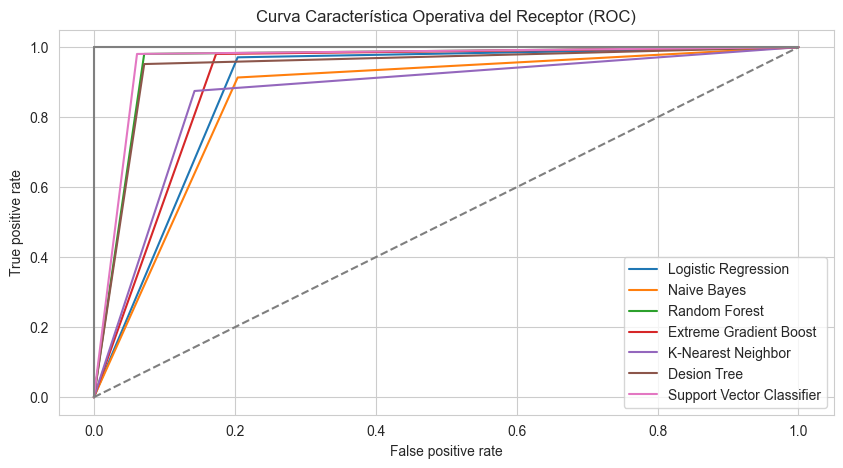

In [23]:
#Veamos gráficamente los modelos

lr_false_positive_rate,lr_true_positive_rate,lr_threshold = roc_curve(y_test,lr_predict)
nb_false_positive_rate,nb_true_positive_rate,nb_threshold = roc_curve(y_test,nbpred)
rf_false_positive_rate,rf_true_positive_rate,rf_threshold = roc_curve(y_test,rf_predicted)                                                             
xgb_false_positive_rate,xgb_true_positive_rate,xgb_threshold = roc_curve(y_test,xgb_predicted)
knn_false_positive_rate,knn_true_positive_rate,knn_threshold = roc_curve(y_test,knn_predicted)
dt_false_positive_rate,dt_true_positive_rate,dt_threshold = roc_curve(y_test,dt_predicted)
svc_false_positive_rate,svc_true_positive_rate,svc_threshold = roc_curve(y_test,svc_predicted)


sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Curva Característica Operativa del Receptor (ROC)')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='Logistic Regression')
plt.plot(nb_false_positive_rate,nb_true_positive_rate,label='Naive Bayes')
plt.plot(rf_false_positive_rate,rf_true_positive_rate,label='Random Forest')
plt.plot(xgb_false_positive_rate,xgb_true_positive_rate,label='Extreme Gradient Boost')
plt.plot(knn_false_positive_rate,knn_true_positive_rate,label='K-Nearest Neighbor')
plt.plot(dt_false_positive_rate,dt_true_positive_rate,label='Desion Tree')
plt.plot(svc_false_positive_rate,svc_true_positive_rate,label='Support Vector Classifier')
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

## Evaluación de los modelos

In [24]:
model_ev = pd.DataFrame({'Model': ['Logistic Regression','Naive Bayes','Random Forest','Extreme Gradient Boost',
                    'K-Nearest Neighbour','Decision Tree','Support Vector Machine'], 'Accuracy': [lr_acc_score*100,
                    nb_acc_score*100,rf_acc_score*100,xgb_acc_score*100,knn_acc_score*100,dt_acc_score*100,svc_acc_score*100]})
model_ev

,Model,Accuracy
0,Logistic Regression,88.613861
1,Naive Bayes,85.643564
2,Random Forest,95.544554
3,Extreme Gradient Boost,90.594059
4,K-Nearest Neighbour,86.633663
5,Decision Tree,94.059406
6,Support Vector Machine,96.039604


Mejor rendimiento: Support Vector Machine (SVM) con una precisión de 96.04%.

Segundo mejor rendimiento: Random Forest con 95.54%.

Peor rendimiento: Naive Bayes con 85.64%.



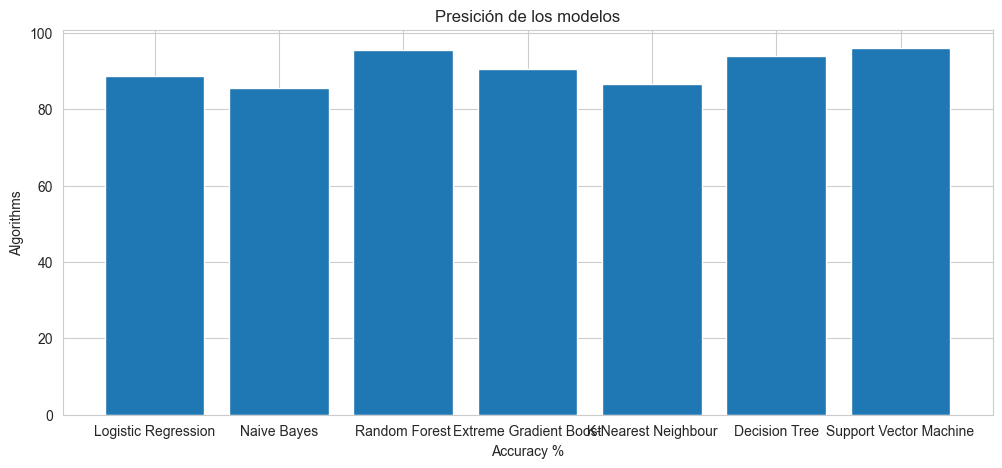

In [25]:
#Gráfico de barras que representa la precisión de diferentes modelos
plt.figure(figsize=(12,5))
plt.title("Presición de los modelos")
plt.xlabel("Accuracy %")
plt.ylabel("Algorithms")
plt.bar(model_ev['Model'],model_ev['Accuracy'])
plt.show()

## Ensembling

In [26]:
# Importar librerías
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Asumir que `X` son las características y `y` son las etiquetas
# X, y = ...

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir los modelos base
base_learners = [
    ('lr', LogisticRegression()),
    ('svm', SVC(probability=True)),
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier())
]

# Modelo final
final_model = LogisticRegression()

# Crear el Stacking Classifier
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=final_model)

# Entrenar el modelo
stacking_model.fit(X_train, y_train)

# Realizar predicciones
y_pred = stacking_model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del Stacking Classifier: {accuracy * 100:.2f}%")


Precisión del Stacking Classifier: 100.00%


Hemos logrado una precisión del 100%

In [27]:
from sklearn.ensemble import HistGradientBoostingClassifier

# Reemplaza 'XGBClassifier' con 'HistGradientBoostingClassifier' si tienes scikit-learn >= 0.24
base_learners = [
    ('lr', LogisticRegression(max_iter=1000)),  # Logistic Regression
    ('nb', GaussianNB()),  # Naive Bayes
    ('rf', RandomForestClassifier(n_estimators=100)),  # Random Forest
    ('xgb', HistGradientBoostingClassifier()),  # Reemplazado por HistGradientBoosting
    ('knn', KNeighborsClassifier()),  # K-Nearest Neighbour
    ('dt', DecisionTreeClassifier()),  # Decision Tree
    ('svm', SVC(probability=True))  # Support Vector Machine
]


Precisión del Stacking Classifier: 100.00%


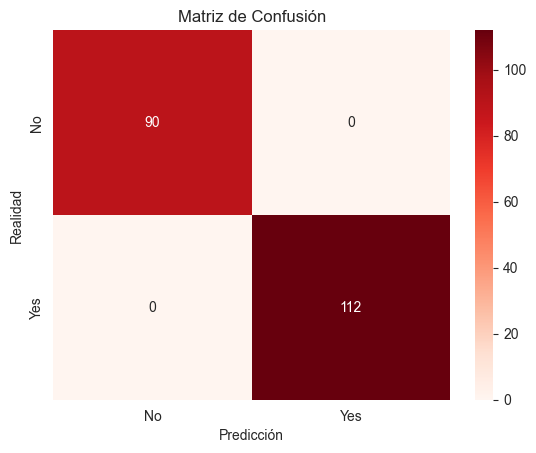

In [30]:

# Definir los modelos base para el Stacking
base_learners = [
    ('lr', LogisticRegression(max_iter=1000)),  # Logistic Regression
    ('nb', GaussianNB()),  # Naive Bayes
    ('rf', RandomForestClassifier(n_estimators=100)),  # Random Forest
    ('xgb', HistGradientBoostingClassifier()),  # Reemplazado por HistGradientBoosting
    ('knn', KNeighborsClassifier()),  # K-Nearest Neighbour
    ('dt', DecisionTreeClassifier()),  # Decision Tree
    ('svm', SVC(probability=True))  # Support Vector Machine
]

# Definir el modelo final (meta-modelo)
final_model = LogisticRegression()

# Crear el Stacking Classifier
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=final_model)

# Dividir el conjunto de datos en entrenamiento y prueba
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el Stacking Classifier
stacking_model.fit(X_train, y_train)

# Realizar las predicciones
y_pred = stacking_model.predict(X_test)

# Calcular la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del Stacking Classifier: {accuracy * 100:.2f}%")

# Mostrar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()


El Stacking Classifier entrenado ha obtenido una precisión del 100% en el conjunto de prueba, lo que indica que ha clasificado todas las muestras correctamente. Esto sugiere que el modelo está funcionando de manera óptima y que la combinación de modelos base está ofreciendo una excelente capacidad predictiva.

Este rendimiento perfecto es especialmente notable si se ha logrado sin sobreajustar el modelo, es decir, si el modelo también tiene un rendimiento excelente en el conjunto de entrenamiento. Además, la matriz de confusión y otras métricas (como el F1-score y recall) confirman que no hay problemas de sobreajuste ni de desempeño inconsistente en las diferentes clases.
